# This is the notebook template for analyzing your Stripe data 😉


This report explores how we can do cohort analysis from our data from Stripe.

If you want to run this notebook, the install instructions are kept in <a href="https://github.com/facundodeza/Stripe_cohort_analysis/blob/master/Readme.md">the Readme.md.</a>


## Introduction

Stripe is a company based in San Francisco and allows its user to make and receive payments over the internet. It has other services that works as an extension, for example, "connect" if you want to implement Stripe in on your own marketplace.


## What do we do here and why?

Here, we are performing 3 analysis.<br> 

a) Share in returning sales from each cohort. This will allow us to know if sales are going up or not. <br>

b) Cohort retention. This will allow us to know if our customers are repeating customers.  <br>

c) LTV for each customer. This will allow us to know how much our customers worth and therefore, how much we can afford to acquire them.<br>

## Lets check if the libraries we want are installed correctly

In [1]:
import os 
import numpy as np
import stripe 
import pandas as pd
from pandas.io.json import json_normalize 
from lifetimes import GammaGammaFitter
from lifetimes import BetaGeoFitter
import matplotlib
import math
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
import seaborn as sns
import matplotlib.colors as mcolors




print(np.__version__)
print(matplotlib.__version__)

1.18.1
3.1.3


Let's also make matplotlib render plots in 4k

## Let’s connect to our Stripe Account 



First, you need a Stripe account and then, your secret key. You can get the secret key from 
<a href="https://dashboard.stripe.com/apikeys">the developer dashboard.</a> 

Remember that your secret key starts with "sk_live..." 





In [2]:
api_key="your_secret_api_key_here"


For retrieving our data we use the "charges" endpoint of Stripe. This API allows retrieving 100 transactions top for each API call. Therefore, we are creating a function that retrieves all the data that we have automatically.

In [3]:

def complete_data(api_key, limit=100):
    
    #We call the API
    stripe.api_key = api_key

    
    temp=stripe.Charge.list(limit=limit)
    
    #We convert the response in a dataframe
    df = json_normalize(temp['data'])

    
    while len(temp) == limit: 
        df=df.reset_index(drop = True) 

        temp=stripe.Charge.list(limit=limit, starting_after=df['id'][df.shape[0]-1])
        df=pd.concat([df, json_normalize(temp['data'])], axis=0)
                    
    return df


Now, we have our function and secret key to retrieve our data and we take a look at the columns that we already have.

In [4]:
my_data= complete_data(api_key)

In [5]:
my_data.columns

Index(['id', 'object', 'amount', 'amount_refunded', 'application',
       'application_fee', 'application_fee_amount', 'balance_transaction',
       'calculated_statement_descriptor', 'captured', 'created', 'currency',
       'customer', 'description', 'destination', 'dispute', 'disputed',
       'failure_code', 'failure_message', 'invoice', 'livemode',
       'on_behalf_of', 'order', 'outcome', 'paid', 'payment_intent',
       'payment_method', 'receipt_email', 'receipt_number', 'receipt_url',
       'refunded', 'review', 'shipping', 'source_transfer',
       'statement_descriptor', 'statement_descriptor_suffix', 'status',
       'transfer_data', 'transfer_group', 'billing_details.address.city',
       'billing_details.address.country', 'billing_details.address.line1',
       'billing_details.address.line2', 'billing_details.address.postal_code',
       'billing_details.address.state', 'billing_details.email',
       'billing_details.name', 'billing_details.phone',
       'payment_met

## Some pre-processing

In this section, we do some pre-processing steps that we need for our analysis.  <br>

We start keeping only the variables that we need.  <br>

We need "amount" and "amount_refunded" for getting a "net_amount" for transaction.  <br>

We need "created" because is the date for each transaction and we use it for obtaining the cohort which customer belongs with formula "year-month". Also, this variable allows us to track if a customer has bought again or not. <br>

The last variable "customer" allows us to distinguish each customer individually. 


In [6]:
my_data=my_data[['amount', 'amount_refunded', 'created', 'customer']]

It is important to notice that amount and amount_refunded are in cents and for that reason, we are dividing per 100. <br>

In the other hand, we want to have the net amount for each transaction, so we are creating such attribute. 

In [7]:
my_data['net_amount']=(my_data['amount']-my_data['amount_refunded'])/100 

Also, the date is a timestamp format. We convert them into a date format.

In [8]:
my_data['created']=my_data['created'].apply(datetime.fromtimestamp)


my_data['created']=my_data['created'].dt.date


We decide to keep only net_amount, customer and created for simplifying our dataset.

In [41]:
my_data=my_data[['net_amount','customer','created']]

my_data.head()

,net_amount,customer,created
0,0.57,0,2015-01-15
1,12.59,0,2015-06-23
2,20.36,0,2015-07-10
3,12.09,0,2015-09-11
4,24.87,1,2015-08-27


To know the cohort which each customer belongs to, we need to get the first purchase for each client.

In [10]:
first_purchase=pd.DataFrame(my_data.groupby(['customer'])['created'].min()).reset_index()

first_purchase.columns =['customer', 'first_purchase'] 

first_purchase.head()

,customer,first_purchase
0,0,2015-01-15
1,1,2015-08-27
2,2,2015-02-05
3,3,2015-01-01
4,4,2015-02-06


Now we merge the first purchase with our original data.

In [11]:
my_data=my_data.merge(first_purchase, how='left',  on='customer')

In [12]:
my_data.head()

,net_amount,customer,created,first_purchase
0,57.37,5634,2015-11-21,2015-03-11
1,2.40,3906,2015-10-02,2015-10-02
2,70.30,8073,2015-08-13,2015-04-01
3,1.65,5297,2015-06-25,2015-01-06
4,32.08,2607,2015-06-19,2015-02-20


We create a new column named "cohort". The cohort follows the formula "Year-month". It means if the cohort is 2015-01 is because this given customer has made his first purchase in January 2015.

In [13]:
my_data['cohort']=pd.to_datetime(my_data['first_purchase']).map(lambda x: x.strftime('%Y-%m'))

For each transaction, we simplify its date to a "Year-month" format.

In [14]:
my_data['monthly']=pd.to_datetime(my_data['created']).map(lambda x: x.strftime('%Y-%m'))


We estimate the period for each transaction and for each client. The period considers frames of 30 days between each transaction and the first purchase for a given customer<br>

For example, if a customer has bought for the first time 2015-01-01 and then he buys again 2015-01-25, the second purchase belongs to period 1. It means it was made within the next 30 days of his first purchase.<br>

Now, if the same client buys again 2015-02-15, this transaction belongs to period 2 because it was made between 30 and 60 days after the first purchase. <br>

The same idea is applied for each customer and each of his transactions.

In [15]:
my_data['created']=pd.to_datetime(my_data['created'])
my_data['first_purchase']=pd.to_datetime(my_data['first_purchase'])

my_data['period']= np.ceil(((my_data['created']-my_data['first_purchase']).dt.days)/30)

my_data.head()

,net_amount,customer,created,first_purchase,cohort,monthly,period
0,57.37,5634,2015-11-21,2015-03-11,2015-03,2015-11,9.0
1,2.40,3906,2015-10-02,2015-10-02,2015-10,2015-10,0.0
2,70.30,8073,2015-08-13,2015-04-01,2015-04,2015-08,5.0
3,1.65,5297,2015-06-25,2015-01-06,2015-01,2015-06,6.0
4,32.08,2607,2015-06-19,2015-02-20,2015-02,2015-06,4.0


## Shares of returning sales from each cohort
The goal here is to determine how each cohort is growing or not, taking sales as a metric. <br>

For example, if one cohort at the time 0 has sold USD 100 and then, at time 4 has sold USD 110, we would 110% in the chart and it is good news because the sales have increased 10% in comparison with moment 0. <br>

If this value is 25%, it means that we only sold 25% in comparison of total sales at moment 0. 


We start calculating the total net sales per cohort and period.

In [16]:
sales=pd.DataFrame(my_data.groupby(['cohort', 'period'])['net_amount'].sum()).reset_index() 

sales.head()


,cohort,period,net_amount
0,2015-01,0.0,58032.31
1,2015-01,1.0,14314.28
2,2015-01,2.0,13832.08
3,2015-01,3.0,13634.57
4,2015-01,4.0,12036.50


Then, we create a pivot table where each row is a cohort, each column is a period and the values of each cells are the total sales for that cohort and period.

In [17]:
sales_monthly = sales.pivot_table(index = 'cohort',
                                     columns = 'period',
                                     values = 'net_amount')

sales_monthly.head()

period,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
cohort,,,,,,,,,,,,,
2015-01,58032.31,14314.28,13832.08,13634.57,12036.50,13077.71,13619.39,14292.34,13043.98,14699.29,13341.66,14357.21,7124.33
2015-02,40388.06,10299.45,10371.23,10543.55,9954.09,10949.96,9940.52,10967.47,10895.82,10753.89,10391.18,6145.31,NaN
2015-03,34808.66,7444.40,9812.08,8376.02,9612.37,9059.66,8849.71,8955.62,9433.74,8100.43,5390.07,NaN,NaN
2015-04,26476.09,6264.45,5554.57,6004.86,6234.14,6248.01,6618.88,6741.28,5773.17,4157.21,NaN,NaN,NaN
2015-05,20591.80,5018.88,5290.65,4875.00,5642.78,5414.14,4766.20,4951.72,2612.91,NaN,NaN,NaN,NaN


Then, we divide them for the total sales at moment 0 and we get which percentage they represent in comparison with total sales at moment 0 of its respective cohort.

In [18]:
sales_monthly_volume = sales_monthly.iloc[:,0]
sales_monthly = sales_monthly.divide(sales_monthly_volume, axis = 0)
sales_monthly.head()

period,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
cohort,,,,,,,,,,,,,
2015-01,1.0,0.246661,0.238351,0.234948,0.207410,0.225352,0.234686,0.246282,0.224771,0.253295,0.229901,0.247400,0.122765
2015-02,1.0,0.255012,0.256790,0.261056,0.246461,0.271119,0.246125,0.271552,0.269778,0.266264,0.257283,0.152157,NaN
2015-03,1.0,0.213866,0.281886,0.240630,0.276149,0.260270,0.254239,0.257281,0.271017,0.232713,0.154849,NaN,NaN
2015-04,1.0,0.236608,0.209796,0.226803,0.235463,0.235987,0.249995,0.254618,0.218052,0.157018,NaN,NaN,NaN
2015-05,1.0,0.243732,0.256930,0.236745,0.274030,0.262927,0.231461,0.240470,0.126891,NaN,NaN,NaN,NaN


For reading this heatmap, from left to right we have: <br>

In the first column, the cohorts. <br>

In the second column, the total sales at moment 0. <br>

Then, we have an entire green column with 100% in each row, this is because it represents the percentage in relation with moment 0 and therefore, a number divided by itself, it is 1. <br>

The rest of the columns represents each period (which you can find on the bottom) and its percentage in comparison to moment 0 as well.<br>

Example:<br>

For the cohort "2015-01" we sold them USD 58032.3 at the beginning (moment 0) but for period 1, we sold them only 25% of original sales done at moment 0. Therefore, the sales for this cohort at period 1 has decreased in comparison with moment 0.

<Figure size 2160x2160 with 0 Axes>

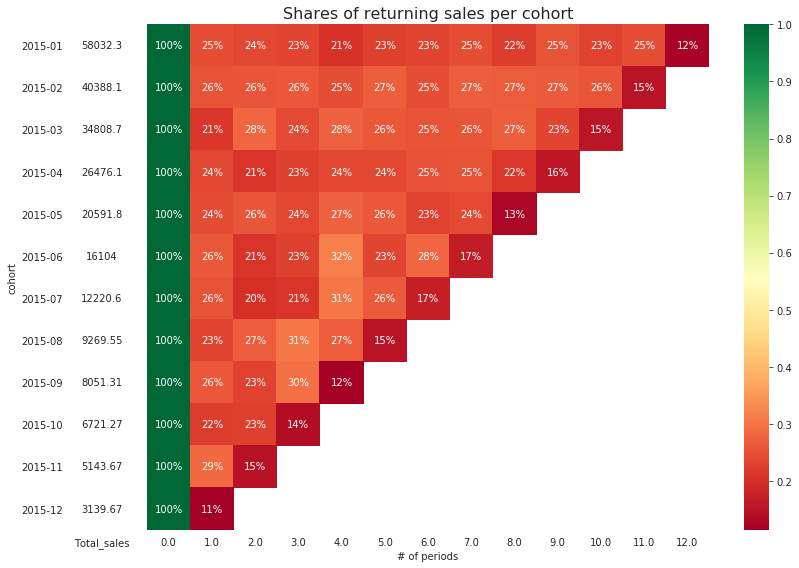

In [19]:
plt.figure(1, figsize=[30,30])

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(sales_monthly, 
                mask=sales_monthly.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Shares of returning sales per cohort', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    sales_monthly_volume_df = pd.DataFrame(sales_monthly_volume).rename(columns={0: 'Total_sales'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(sales_monthly_volume_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

## Are they leaving or staying? Cohort retention 

Cohort retention is a good way to know about how is the engagement between our customers and us. This measures if a given customer has made, at least one purchase, in the following periods. <br>

The other view of this is that acquiring customer might be expensive and therefore, we need to be able to retain them as long as possible. <br>

We only count one transaction per customer and period.

In [20]:
cohort= my_data.drop_duplicates(subset=['cohort', 'period', 'customer'], keep='first', inplace=False)

cohort.head()

,net_amount,customer,created,first_purchase,cohort,monthly,period
0,57.37,5634,2015-11-21,2015-03-11,2015-03,2015-11,9.0
1,2.40,3906,2015-10-02,2015-10-02,2015-10,2015-10,0.0
2,70.30,8073,2015-08-13,2015-04-01,2015-04,2015-08,5.0
3,1.65,5297,2015-06-25,2015-01-06,2015-01,2015-06,6.0
4,32.08,2607,2015-06-19,2015-02-20,2015-02,2015-06,4.0


After getting one transaction per customer and period, we count how many customers we have per cohort and period.

In [21]:
cohort_number=pd.DataFrame(cohort.groupby(['period', 'cohort'])['customer'].count()).reset_index()

cohort_number.head()

,period,cohort,customer
0,0.0,2015-01,2240
1,0.0,2015-02,1608
2,0.0,2015-03,1408
3,0.0,2015-04,996
4,0.0,2015-05,809


We create a pivot table where each row is a cohort, each column is a period and the values of each cell are the number of customers for that cohort and period.

In [22]:
cohort_pivot_table = cohort_number.pivot_table(index = 'cohort',
                                     columns = 'period',
                                     values = 'customer')
cohort_pivot_table

period,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
cohort,,,,,,,,,,,,,
2015-01,2240.0,506.0,508.0,477.0,452.0,476.0,500.0,507.0,458.0,523.0,495.0,506.0,274.0
2015-02,1608.0,364.0,339.0,372.0,359.0,358.0,372.0,377.0,371.0,357.0,378.0,224.0,NaN
2015-03,1408.0,279.0,342.0,299.0,322.0,308.0,298.0,316.0,330.0,313.0,187.0,NaN,NaN
2015-04,996.0,222.0,206.0,210.0,221.0,215.0,228.0,240.0,212.0,143.0,NaN,NaN,NaN
2015-05,809.0,170.0,177.0,166.0,183.0,180.0,178.0,176.0,92.0,NaN,NaN,NaN,NaN
2015-06,645.0,161.0,132.0,154.0,158.0,131.0,142.0,85.0,NaN,NaN,NaN,NaN,NaN
2015-07,497.0,111.0,96.0,101.0,125.0,116.0,65.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-08,380.0,76.0,80.0,89.0,86.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09,310.0,66.0,70.0,75.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For this step, we get the beginning size for each cohort and divide the number of customers of each cohort and each period for the beginning size of its respective cohort. 

In [23]:
cohort_size = cohort_pivot_table.iloc[:,0]
cohort_retention = cohort_pivot_table.divide(cohort_size, axis = 0)

cohort_retention

period,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
cohort,,,,,,,,,,,,,
2015-01,1.0,0.225893,0.226786,0.212946,0.201786,0.212500,0.223214,0.226339,0.204464,0.233482,0.220982,0.225893,0.122321
2015-02,1.0,0.226368,0.210821,0.231343,0.223259,0.222637,0.231343,0.234453,0.230721,0.222015,0.235075,0.139303,NaN
2015-03,1.0,0.198153,0.242898,0.212358,0.228693,0.218750,0.211648,0.224432,0.234375,0.222301,0.132812,NaN,NaN
2015-04,1.0,0.222892,0.206827,0.210843,0.221888,0.215863,0.228916,0.240964,0.212851,0.143574,NaN,NaN,NaN
2015-05,1.0,0.210136,0.218789,0.205192,0.226205,0.222497,0.220025,0.217553,0.113721,NaN,NaN,NaN,NaN
2015-06,1.0,0.249612,0.204651,0.238760,0.244961,0.203101,0.220155,0.131783,NaN,NaN,NaN,NaN,NaN
2015-07,1.0,0.223340,0.193159,0.203219,0.251509,0.233400,0.130785,NaN,NaN,NaN,NaN,NaN,NaN
2015-08,1.0,0.200000,0.210526,0.234211,0.226316,0.126316,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09,1.0,0.212903,0.225806,0.241935,0.129032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


For reading this heatmap, from left to right we have: <br>

In the first column, the cohorts. <br>

In the second column, the total customers at moment 0. <br>

Then, we have an entire green column with 100% in each row, this is because it represents the percentage in relation with moment 0 and therefore, a number divided by itself, it is 1. <br>

The rest of the columns represents each period (which you can find on the bottom) and its percentage in comparison at moment 0 as well.<br>

Example:<br>

The cohort "2015-01" started with 2240 customers but during period 1 only 23% of them have purchased again.

<Figure size 2160x2160 with 0 Axes>

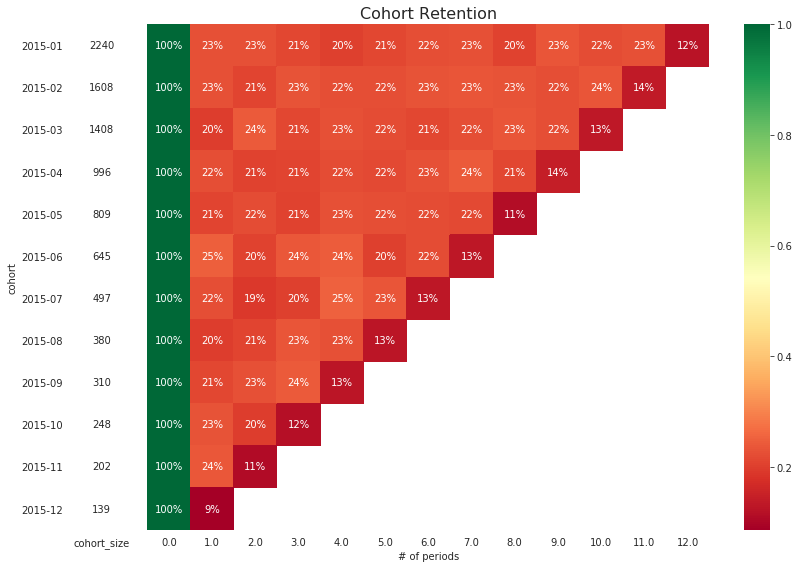

In [24]:
plt.figure(1, figsize=[30,30])

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(cohort_retention, 
                mask=cohort_retention.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Cohort Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

## How much are my customers worth it? Using Life Time Value
LTV is a financial concept taken from investment valuation and it is the actual value of investment (or customer) based on his discounted cash flow. This is a very useful metric because allows you to know how much you can spend in customer acquisition. As you long as you have LTV bigger than your customer acquisition cost, you have a business.<br>

LTV relies on several aspects and some of them are tricky to get: <br>

Lifespan: it means how many a customer remains like a customer. <br>

AOV: Average order value, it means how much -on average- a customer spends in your business. <br>

Purchase frequency: In a given period of time, it is the number of times a customer has bought.  <br>

Our data needs to have the next variables for our models which will be explained later in our notebook<br>

<dd>a) Frequency: It is the number of periods where each customer has made at least one repeat purchase. If the period is measured in days, in the numbers of days which at least one purchase. <br></dd> 

<dd>b) T: is the age of customer in the unit time we choose, considering her first purchase and the end of the period under study. In our case, the end of the period will be the last transaction between all the transactions.  <br></dd> 

<dd>c) Recency: It is similar to T but it takes the last transaction for each customer  <br></dd> 

<dd>d) Monetary value: It is the average value of each purchase for a given customer<br></dd> 


Lets started to estimate the frequency and remember that time unit here is in days.  <br>
The first step is to get the customers who have bought again, at least one more time.

In [25]:
my_data=my_data.sort_values(['customer','created']).reset_index()
share_returning=my_data.duplicated(subset='customer', keep='first')

share_returning.head()

0    False
1     True
2     True
3     True
4    False
dtype: bool

The next step is to get the frequency for the time frame that we have chosen. If we would have chosen another timeframe like weeks, the frequency counts how many weeks a given customer has bought at least one time.

In [26]:
frequency=pd.DataFrame(my_data[share_returning].groupby(['customer'])['net_amount'].count()).reset_index()
frequency.columns =['customer', 'frequency'] 
frequency.head()

,customer,frequency
0,0,3
1,1,1
2,2,6
3,3,2
4,4,6


Now, we will estimate T using the oldest transaction in our data and the first transaction for each customer. <br>


In [27]:
my_data['T']=(max(my_data['created'])-my_data['first_purchase']).dt.days

In [28]:
#We deletes duplicates customers. Same customer has same T.
T=my_data.drop_duplicates(subset='customer', keep='first')
T=T[['customer','T']]
T.head()

,customer,T
0,0,349
4,1,125
6,2,328
13,3,363
16,4,327


For estimating recency, we calculate the last transaction for each customer.

In [29]:
last_purchase=pd.DataFrame(my_data.groupby(['customer'])['created'].max()).reset_index()

last_purchase.columns =['customer', 'last_purchase'] 

A glimpse of last_purchase.

In [30]:
last_purchase.head()

,customer,last_purchase
0,0,2015-09-11
1,1,2015-12-11
2,2,2015-10-24
3,3,2015-10-08
4,4,2015-12-09


Then we merge this last_purchase with our first_purchase data frame for getting our recency, which is the difference between last purchase and the first purchase for each customer.

In [31]:
recency=first_purchase.merge(last_purchase, how='inner', on='customer')
recency.head()

recency['last_purchase']=pd.to_datetime(recency['last_purchase'])
recency['first_purchase']=pd.to_datetime(recency['first_purchase'])

In [32]:
recency['recency']= (recency['last_purchase']-recency['first_purchase']).dt.days
recency= recency[['customer','recency']]
recency.head()


,customer,recency
0,0,239
1,1,106
2,2,261
3,3,280
4,4,306


The last variable we need is monetary value, that is the average order value per customer.

In [33]:
monetary=pd.DataFrame(my_data.groupby(['customer'])['net_amount'].mean()).reset_index()
monetary.columns =['customer', 'monetary_value'] 
monetary.head()

,customer,monetary_value
0,0,11.402500
1,1,15.440000
2,2,15.188571
3,3,36.520000
4,4,6.137143


Now, we put gather all the variables together.

In [34]:
ltv=T.merge(frequency, how='left', on= 'customer').merge(recency, how='left', on= 'customer').merge(monetary, how='left',  on= 'customer')
ltv=ltv.fillna(0)
ltv.head()

,customer,T,frequency,recency,monetary_value
0,0,349,3,239,11.402500
1,1,125,1,106,15.440000
2,2,328,6,261,15.188571
3,3,363,2,280,36.520000
4,4,327,6,306,6.137143


For estimating LTV we use two models. <br>

The Gamma Gamma Model is responsible for modelling the expected transaction value for each customer based on the monetary value and frequency. <br>

The other model is the BG/NBD model. This is one is responsible for modelling the expected number of transactions
per customer in given period times, for example, the next 12 months.  <br>

With the expected transactions value and expected number of transaction for each customer, we can use them for estimating our LTV per customer.





## The Gamma Gamma Model

Gamma Gamma Model has an assumption that frequency and monetary value are not correlated. We use Pearson for checking said assumption.

In [35]:
ltv[['monetary_value', 'frequency']].corr()


,monetary_value,frequency
monetary_value,1.000000,-0.008844
frequency,-0.008844,1.000000


Once we checked that monetary value and frequency are not correlated, we fit the model. <br>

You should consider that model might not fit because you may have a lot a customer who have only bought once. <br>

For this you have two solutions, you filter such customers or you play around with the "penalizer_coef" for fitting the model. The latter might not work every set of data. 

In [36]:
ggf = GammaGammaFitter(penalizer_coef = 0.01)
ggf.fit(ltv['frequency'],
        ltv['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 7963 subjects, p: 3.93, q: 1.08, v: 3.74>


## The BG/NBD model

You might have similar issues with the BG/NBD model, you might need to play with the penalizer_coef as well if it is required.

In [37]:
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(ltv['frequency'], ltv['recency'], ltv['T'])

<lifetimes.BetaGeoFitter: fitted with 7963 subjects, a: 0.00, alpha: 120.14, b: 0.00, r: 1.18>

## Using the two models for getting our LTV value for each customer

Now, we estimate the LTV for each customer and we are including a discount rate. This discount rate considers the value of money from a time perspective.<br>

For example, having USD 100 today is worthier than having USD 100 in one year from now.

In [38]:
expected_ltv= round(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    ltv['frequency'],
    ltv['recency'],
    ltv['T'],
    ltv['monetary_value'],
    time=12, # months
    discount_rate=0.01, # monthly discount rate ~ 12.7% annually
    freq='D'

), 2) 

We can see that customer 0 is worth USD 37.77 and the customer 1 is worthier than customer 0 because her value is USD 56.34

In [39]:
expected_ltv=pd.DataFrame(expected_ltv).reset_index()
expected_ltv.columns = ['customer', 'LTV']
expected_ltv.head()


,customer,LTV
0,0,37.77
1,1,56.34
2,2,85.21
3,3,84.37
4,4,36.51


We can estimate the average life timevalue for our customers. 

In [40]:
mean_ltv= np.mean(expected_ltv['LTV'])

print('The average LTV for your customers is USD '+ str(round(mean_ltv, 2))+' and you should spend less than that for being profitable.')

The average LTV for your customers is USD 86.91 and you should spend less than that for being profitable.


References: <br>
https://lifetimes.readthedocs.io/en/latest/index.html<br>
https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea<br>
